# Do the grades students receive influence the ratings they leave on professor reviews?
Among people who design course review websites, there is a common concern that the reviews of the professors
paint a misleading picture. The idea is that if a professor is teaching a difficult course, then the average grades they give out will likely be lower. As a result, students will be more likely to negatively rate their experience with that professor, and if someone reads their reviews, they may get the wrong impression that the professor is bad when in reality,
it's just that the course they teach is more difficult. 

In this analysis, I will use grade and review data from PlanetTerp to look at the relationship between a professor's ratings
and the grades they give out. According to the PlanetTerp website, the review data comes in part from OurUMD.com. 
Professor and course information comes from umd.io. Grade data comes from the UMD Office of Institutional Research, Planning & Assessment (IRPA) and through a request under the state of Maryland's Public Information Act (PIA) (grade data initially from VAgrades.com).

The null hypothesis will be that there is a positive correlation between a professor's ratings and the grades they give out in their courses.

# Average Rating vs. Average GPA

Our first task will be to gather some data. There are two things that we need to start out. The average rating of each professor and their average GPA over all the courses they teach. The first of these is really easy. The PlanetTerp API provides the average rating for a requested professor when you hit a certain endpoint.

First, we need to get all of the professors. We will use this code below to build a dataframe object that contains the following properties:
- name: name of professor
- slug
- type: professor or TA
- courses: list of courses taught
- average_rating


In [219]:
import requests
import pandas as pd
import io
import time
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

cur_offset = 0
professor_df = None
while cur_offset < 11039:
    time.sleep(3)
    # print(f"Requesting data. Offset is {cur_offset}")
    req = requests.get(f"https://api.planetterp.com/v1/professors?limit=1000&offset={cur_offset}").content
    df = pd.read_json(io.StringIO(req.decode('utf-8')))
    cur_offset += 1000
    if professor_df is None:
        professor_df = df
    else:
        professor_df = professor_df.append(df)


In [220]:
professor_df = professor_df.loc[professor_df["type"] == "professor"] # Filter out all the TA's
professor_df = professor_df[professor_df["average_rating"].notna()] # Drop anyone who doesn't have any ratings
professor_df

,name,slug,type,courses,average_rating
1,A Anthony,anthony,professor,"[AMST202, AMST203, AMST101]",1.00
2,A Kruglanski,kruglanski,professor,"[PSYC743, PSYC748M, PSYC489H, PSYC489T, PSYC78...",2.00
4,A Sharma,sharma_a,professor,[ASTR300],1.80
6,A.U. Shankar,shankar_a.u.,professor,"[CMSC412, CMSC414, CMSC712, CMSC216, CMSC798]",2.10
8,Aaron Allen,allen_aaron,professor,"[HHUM205, HHUM206]",5.00
...,...,...,...,...,...
4,Zhengguo Xiao,xiao_zhengguo,professor,"[ANSC460, ANSC214, GEMS296, ANSC212, GEMS297, ...",4.00
20,Zhongchi Liu,liu_zhongchi,professor,"[BSCI378H, BSCI410, CBMG699Y, MOCB899]",4.50
29,Zita Nunes,nunes_zita,professor,"[ENGL234, ENGL749B, ENGL448B, ENGL300, ENGL301...",3.75
32,Zohreh Davoudi,davoudi,professor,"[PHYS604, PHYS411, PHYS624]",2.50


Now that we have a table for our professors, we need to figure out the average GPA they give out for their courses. We'll do this by navigating to their page on PlanetTerp and scraping the content using BeautifulSoup.

In [221]:
import re

base_url = "https://planetterp.com/professor/"
matches = []
for idx, row in professor_df.iterrows():
    time.sleep(0.1)
    r = requests.get(base_url + row["slug"])
    root = BeautifulSoup(r.content, "html")
    s = root.find("strong", id="grade-statistics") 
    # print(s)
    search_res = re.search(r"\d\.\d{2}", str(s))
    if search_res is None:
        # print(row["slug"])
        matches.append(float("NaN"))
    else:
        matches.append(search_res.group(0))

In [222]:
professor_df["average_gpa"] = matches
old_professor_df = professor_df
professor_df = professor_df[professor_df["average_gpa"].notna()] # Drop anyone who doesn't have an average gpa
professor_df

,name,slug,type,courses,average_rating,average_gpa
1,A Anthony,anthony,professor,"[AMST202, AMST203, AMST101]",1.00,2.48
2,A Kruglanski,kruglanski,professor,"[PSYC743, PSYC748M, PSYC489H, PSYC489T, PSYC78...",2.00,3.49
4,A Sharma,sharma_a,professor,[ASTR300],1.80,2.82
6,A.U. Shankar,shankar_a.u.,professor,"[CMSC412, CMSC414, CMSC712, CMSC216, CMSC798]",2.10,2.41
8,Aaron Allen,allen_aaron,professor,"[HHUM205, HHUM206]",5.00,3.61
...,...,...,...,...,...,...
4,Zhengguo Xiao,xiao_zhengguo,professor,"[ANSC460, ANSC214, GEMS296, ANSC212, GEMS297, ...",4.00,2.95
20,Zhongchi Liu,liu_zhongchi,professor,"[BSCI378H, BSCI410, CBMG699Y, MOCB899]",4.50,3.37
29,Zita Nunes,nunes_zita,professor,"[ENGL234, ENGL749B, ENGL448B, ENGL300, ENGL301...",3.75,2.75
32,Zohreh Davoudi,davoudi,professor,"[PHYS604, PHYS411, PHYS624]",2.50,3.38


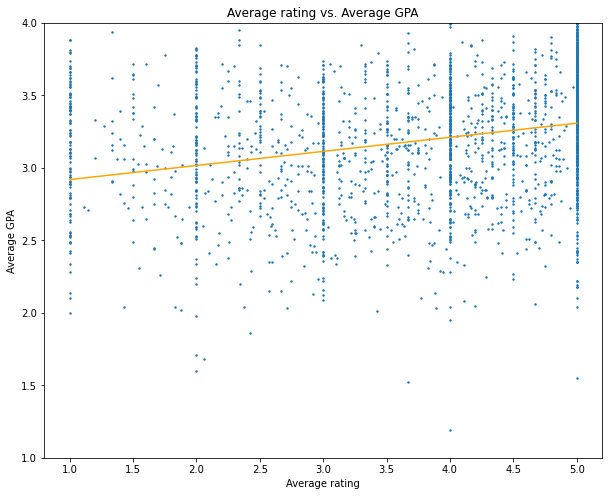

In [223]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [10, 8]
average_rating = [float(x) for x in professor_df["average_rating"]]
average_gpa = [float(x) for x in professor_df["average_gpa"]]
# print(average_gpa)
plt.scatter(x=average_rating, y=average_gpa, s=2)
plt.title("Average rating vs. Average GPA")
plt.xlabel("Average rating")
plt.ylabel("Average GPA")
plt.ylim([1,4])
plt.plot(np.unique(average_rating), np.poly1d(np.polyfit(average_rating, average_gpa, 1))(np.unique(average_rating)), c = "orange")
plt.show()

Due to the volume of data, I've made each point rather small so that we can better distinguish between the different data points. As expected, there are a lot of points concentrated on ratings that are whole numbers (1.0, 2.0, 3.0, 4.0, 5.0). This is likely because not every professor has multiple reviews and even the ones who do may have just a few reviews that are all of the same rating. However, despite the volume of data points, we can see that there seems to be a large density of points around the 5.0 rating and they seem to be skewed towards high GPA. Furthermore, the line of best fit seems to show that there is some positive relationship between the two measures. Let's calculate the R squared value to be sure.

In [224]:
import statsmodels.formula.api as smf
res = smf.ols(formula="average_rating ~ average_gpa", data=professor_df).fit()
print('R squared: {}'.format(res.rsquared))

R squared: 0.15051243926885027


While an R squared value of 0.15 is not huge, it does seem appropriate given what we are measuring. There are a lot of factors that students take into consideration when rating a professor, such as how organized the class was, the professor's lecture style, how good the TA's were, etc. Furthermore, even if a student receives a low grade, it could be the case that they received that grade just because the class was difficult, and it had nothing to do with the quality of the professor. When  you consider the multitude of factors that influence the reviews students give, anything more than a modest relationship between the professor's rating and their average GPA would seem suspicious. 

# Another Approach

There may be a better, more direct way to go about measuring this relationship. On PlanetTerp, when you leave a review, there is an option to leave what grade you are expecting in the class. Instead of just measuring the average GPA of a professor across all the courses that he/she teaches, we could instead look at the individual reviews for each professor and see if there is a relationship between the grade that the reviewer is expecting to get and the rating they give the professor.

In the code below, I've marked down the grades as A, B, C, D, F, Pass (P), Withdrawn (W), and Not Reported (NR). The expectation is that those who received high grades (A's and B's) are likely going to leave higher ratings than those who recieved low grades. We also expect that people who withdrew from the class, passed the class (which was likely a lot of people during the COVID semesters), or simply didn't report the grade they got will give lower ratings to the professors.

This next block of code takes a long time to run, so you might want to go for a walk or put on a TV show if you are going to try and run this snippet yourself. 

In [225]:
grades = {
    "A": {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0}, 
    "B": {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0}, 
    "C": {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0}, 
    "D": {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0},
    "F": {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0},
    "P": {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0},
    "W": {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0},
    "NR": {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0}
}
g = ["A", "B", "C", "D", "F", "P", "W"]
for idx, row in professor_df.iterrows():
    # print(idx)
    reviews = requests.get(f"https://api.planetterp.com/v1/professor?name={row['name']}&reviews=true").json()
    if reviews is None or "reviews" not in reviews:
        # print(reviews)
        continue
    reviews = reviews["reviews"]
    for rev in reviews:
        if rev["expected_grade"] == "" or rev["expected_grade"] is None:
            # print(rev["course"])
            grades["NR"][str(rev["rating"])] += 1
            continue
        grade = rev["expected_grade"][0].upper()
        if grade not in g:
            # print(f"Continuing, {grade}")
            continue
        # print(grade)
        grades[grade][str(rev["rating"])] += 1

Text(69.0, 0.5, 'Grades')

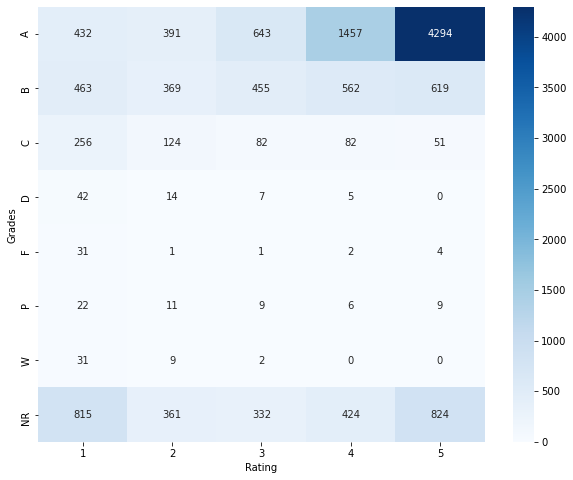

In [226]:
data = [np.array(list(d.values())) for d in grades.values()]
import seaborn as sb
sb.heatmap(data, xticklabels="12345", yticklabels=["A", "B", "C", "D", "F", "P", "W", "NR"], cmap="Blues", annot=True, fmt="g");
plt.xlabel("Rating")
plt.ylabel("Grades")

Wow. That certainly tells us something about the kinds of people who are leaving reviews on PlanetTerp. It's not even a contest. People who gave their professor 5-star ratings and also got A's in the class make up the grand majority of the reviews on the site. The group that comes in second place (people who got A's and left 4-star reviews) has less than half the number of people in this majority group. All other groups look absolutely tiny by comparison, as evidenced by the fact that they are all colored a very pale blue. 

It is worth noting that all of the trends that we anticipated seem to be born out in this heat map. If we look at each of the different grade categories, we can see that people who got A's are overwhelmingly more likely to leave high reviews. The people who got B's, on the other hand, seem to have a more mixed relationship with a pretty even spread among the different ratings. People who got C's or lower were skewed in the opposite direction as those who got A's, with more people leaving low ratings. This is also true of those who passed or withdrew from the class.

It is also interesting to observe that there doesn't seem to be a clear relationship between not reporting one's grade and the rating. In the group of people who didn't report their grades, we see that about the same number of people of people left 1-star and 5-star ratings, with the rest pretty evenly spread among 2 to 4-star ratings.

You might find the pie charts below to be helpful in seeing these proportions among the different grade categories more clearly.

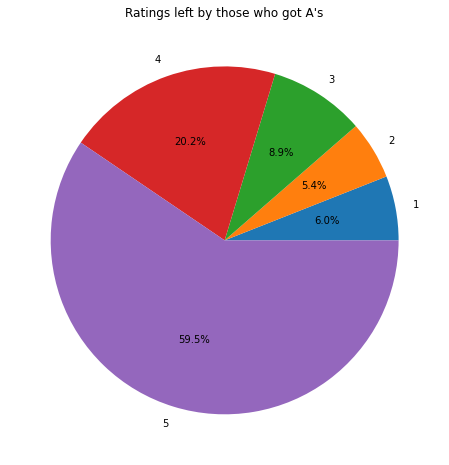

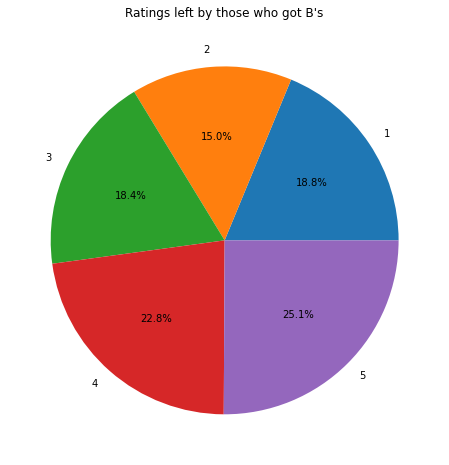

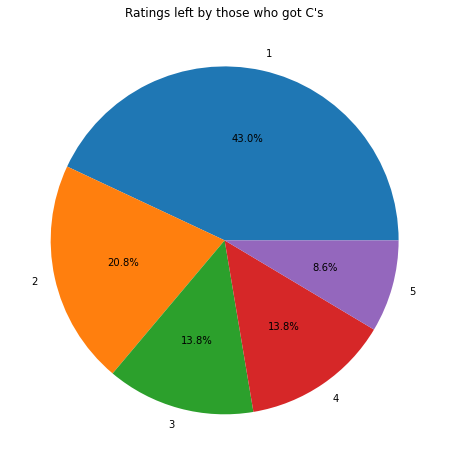

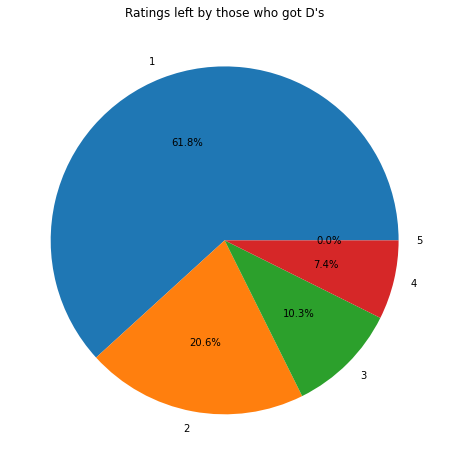

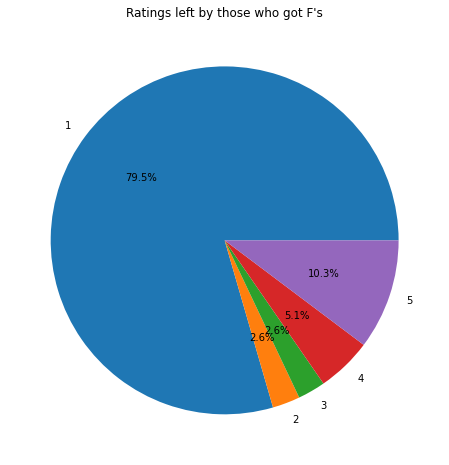

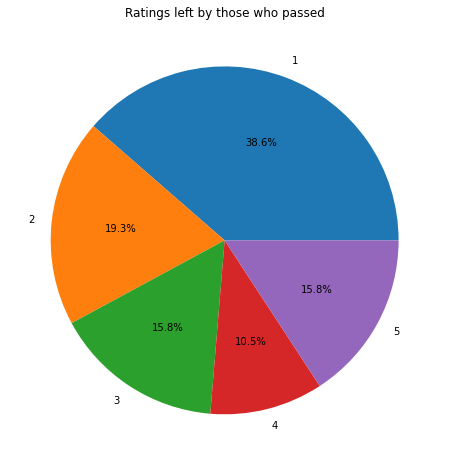

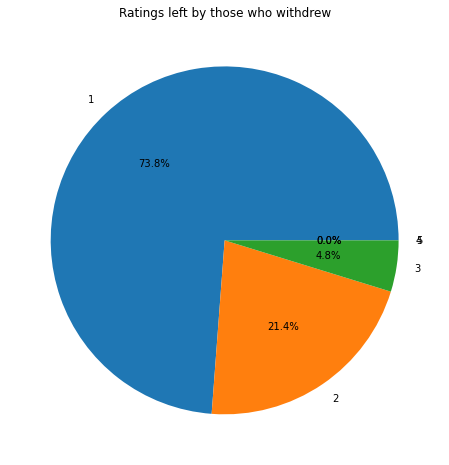

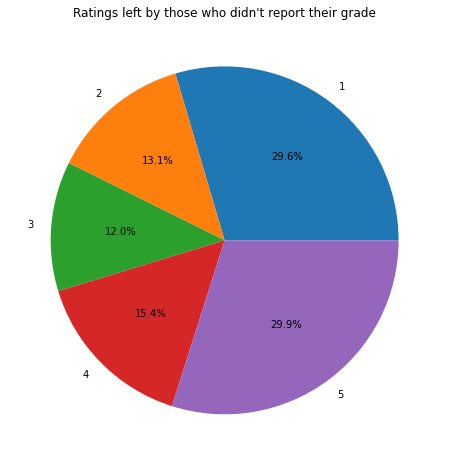

In [227]:
def get_title(grade):
    switcher={
        "A": "those who got A's",
        "B": "those who got B's",
        "C": "those who got C's",
        "D": "those who got D's",
        "F": "those who got F's",
        "P": "those who passed",
        "W": "those who withdrew",
        "NR": "those who didn't report their grade"
    }
    return switcher.get(grade)
        
for grade in grades.keys():
    title = f"Ratings left by {get_title(grade)}"
    ratings = grades[grade]
    rate_vals = []
    for rating in ratings.values():
        rate_vals.append(rating)
    labels = ["1", "2", "3", "4", "5"]
    plt.pie(rate_vals,labels=labels, autopct='%1.1f%%')
    plt.title(title)
    plt.show()


# A new measure?

Given our analysis so far, it seems fair to conclude that people who leave reviews on PlanetTerp are more likely to be people who received high grades in the courses they are reviewing. This presents a problem for those who are relying on PlanetTerp reviews and rating data to determine the quality of a professor, as these ratings might be biased towards professors who simply teach easy classes or grade easily. In this last part of the analysis, let's try and see if we can devise a way to measure the quality of a professor that doesn't suffer from the issues we face with the current information. I think that it's fair to say that if a student receives a high grade in a class, but rates the professor very low, then that indicates that the professor might not be very good. Similarly, if a student receives a low grade, but still rates the professor very highly, that would be a strong indication that the professor is very good. Obviously, it's not perfect. For example, some professors might still be very bad, but have cool personalities that cause students to still leave high ratings and vice versa. However, analyzing the review data in this way might yield some interesting results. 

I'm going to only create this score for professors that have more than 20 ratings, as it likely wouldn't be very meaningful otherwise. 

In [233]:
def get_number_ratings(prof_df):
    ratings_count = []
    for idx, row in prof_df.iterrows():
        # print(idx)
        reviews = requests.get(f"https://api.planetterp.com/v1/professor?name={row['name']}&reviews=true").json()
        if reviews is None or "reviews" not in reviews:
            ratings_count.append(float("NaN"))
            continue
        reviews = reviews["reviews"]
        ratings_count.append(len(reviews))
    return ratings_count

num_ratings = get_number_ratings(professor_df)
professor_df["num_ratings"] = num_ratings
professor_df


<ipython-input-233-71b2b9d75309>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  professor_df["num_ratings"] = num_ratings


,name,slug,type,courses,average_rating,average_gpa,num_ratings
1,A Anthony,anthony,professor,"[AMST202, AMST203, AMST101]",1.00,2.48,1.0
2,A Kruglanski,kruglanski,professor,"[PSYC743, PSYC748M, PSYC489H, PSYC489T, PSYC78...",2.00,3.49,1.0
4,A Sharma,sharma_a,professor,[ASTR300],1.80,2.82,5.0
6,A.U. Shankar,shankar_a.u.,professor,"[CMSC412, CMSC414, CMSC712, CMSC216, CMSC798]",2.10,2.41,20.0
8,Aaron Allen,allen_aaron,professor,"[HHUM205, HHUM206]",5.00,3.61,1.0
...,...,...,...,...,...,...,...
4,Zhengguo Xiao,xiao_zhengguo,professor,"[ANSC460, ANSC214, GEMS296, ANSC212, GEMS297, ...",4.00,2.95,1.0
20,Zhongchi Liu,liu_zhongchi,professor,"[BSCI378H, BSCI410, CBMG699Y, MOCB899]",4.50,3.37,6.0
29,Zita Nunes,nunes_zita,professor,"[ENGL234, ENGL749B, ENGL448B, ENGL300, ENGL301...",3.75,2.75,4.0
32,Zohreh Davoudi,davoudi,professor,"[PHYS604, PHYS411, PHYS624]",2.50,3.38,2.0


In [229]:
more_than_20 = professor_df.loc[professor_df["num_ratings"] >= 20]
more_than_20

,name,slug,type,courses,average_rating,average_gpa,num_ratings
6,A.U. Shankar,shankar_a.u.,professor,"[CMSC412, CMSC414, CMSC712, CMSC216, CMSC798]",2.1000,2.41,20.0
124,Adrianos Papamarcou,papamarcou,professor,"[ENEE222, ENEE324, ENEE620, ENEE322, ENEE322H,...",4.2400,2.87,25.0
331,Alice Mignerey,mignerey,professor,"[CHEM271, CHEM705, CHEM889A, CHEM403, CHEM131,...",2.4444,2.59,36.0
362,Alka Gandhi,gandhi,professor,"[ECON312, ECON422, ECON321, ECON325]",3.8788,2.14,33.0
369,Allan Yashinski,yashinski,professor,"[MATH240, MATH401, MATH406, MATH461, MATH141H,...",4.6400,2.72,25.0
...,...,...,...,...,...,...,...
605,Wesley Lawson,lawson_wesley,professor,"[ENEE131, ENEE132, ENEE200, ENEE205, ENEE381, ...",3.7027,3.10,37.0
649,William Higgins,higgins_william,professor,"[BIOL608F, BSCI440, BSCI105, BSCI207, CLFS510,...",3.4082,2.66,49.0
676,William McClenahan,mcclenahan,professor,"[BMGT380H, BMGT381, BMGT380, BUSI764, BMGT496,...",4.1250,3.10,24.0
727,Wiseley Wong,wong_wiseley,professor,"[MATH141, MATH241H, MATH401, MATH241, MATH475,...",4.8621,2.49,29.0


In [230]:
def get_grade_point(grade):
    switcher={
        "A": 5,
        "B": 4,
        "C": 3,
        "D": 2,
        "F": 1,
        "P": 1,
        "W": 1
    }
    return switcher.get(grade)

g = ["A", "B", "C", "D", "F", "P", "W"]
scores = []
for idx, row in more_than_20.iterrows():
    reviews = requests.get(f"https://api.planetterp.com/v1/professor?name={row['name']}&reviews=true").json()
    reviews = reviews["reviews"]
    cur_score = 0
    for rev in reviews:
        if rev["expected_grade"] == "" or rev["expected_grade"] is None:
            continue
        grade = rev["expected_grade"][0].upper()
        if grade not in g:
            continue
        # print(grade)
        rating = rev["rating"]
        cur_score += rating - get_grade_point(grade) # High rating, low grade -> high score. Low rating, high grade -> low score
    scores.append(cur_score)

In [231]:
more_than_20["score"] = scores

<ipython-input-231-76e9b4c5cf59>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  more_than_20["score"] = scores


In [232]:
sorted_by_score = more_than_20.sort_values(by=["score"],ascending=False)
sorted_by_score.head(40)

,name,slug,type,courses,average_rating,average_gpa,num_ratings,score
386,Justin Wyss-Gallifent,wyss-gallifent,professor,"[MATH206, MATH241, MATH410, MATH695, HONR219O,...",4.9149,3.29,141.0,21
724,Stefan Doboszczak,doboszczak,professor,"[AMSC460, CMSC460, MATH140, MATH410, MATH120, ...",4.9500,2.72,20.0,7
369,Allan Yashinski,yashinski,professor,"[MATH240, MATH401, MATH406, MATH461, MATH141H,...",4.6400,2.72,25.0,6
467,Jeffery Davis,davis_jeffery,professor,"[CHEM241, CHEM611, CHEM889D, CHEM648F, CHEM640...",4.7407,2.81,27.0,5
352,Michael Galczynski,galczynski,professor,"[ENES100, ENES100A, ENES113, ENES102, ENES102H...",4.9677,3.56,31.0,3
997,Elizabeth Griffith,griffith,professor,"[CHEM135, CHEM482, CHEM177, CHEM271, CHEM131, ...",4.4167,2.57,24.0,3
823,Steven Chadwick,chadwick,professor,"[MATH140, MATH140H, STAT410, MATH141, MATH401,...",4.2000,2.57,20.0,3
434,Michael Ross,ross_michael,professor,"[HIST289K, HIST455, HIST454, HIST619R, HIST131...",4.4286,3.14,21.0,2
513,David Straney,straney,professor,"[BSCI222, CPSP219L, BSCI348R, BSCI415]",4.8621,3.01,29.0,2
803,Anne Simon,simon_anne,professor,"[BSCI105C, BSCI105S, CBMG688B, CBMG688X, BSCI1...",3.2245,3.17,49.0,1


Ok so it looks like my new measure might be a little bit too harsh, as the mean is -21. On the other hand, it has also reaffirmed to me that at the top of all things teaching at UMD is always Justin Wyss-Gallifent. His score is triple the next-highest score. Looking at the data in this table, it's really interesting to see where different teachers land. As a student who has taken classes with a number of these professors, I notice certain ones that appear lower than I would have thought, and others that appear higher than I would have thought.

# Conclusion
Students lead stressful lives, and trying to determine which professors will give the best learning experience is a very tricky task. Consulting different sources of data, such as ratings on PlanetTerp, is one approach to tackling this task. However, as we've seen through this analysis, there are problems with the kind of data that you see on PlanetTerp ratings (and likely with other similar review sites). It does seem to be the case that these sites are dominated by students who receive high marks in the courses they are reviewing, which could lead to biased data that paints an inaccurate picture of which professors will be best. However, it does still seem to be possible to harness the ratings data in a way that combats these biases. 

For future research, I believe there is a lot of potential for using grade and rating data to help students. One possibility would be some way for students to see how well they are likely to do in future courses based on their past performance. A big issue that I've encountered as a student is knowing how difficult a courseload will likely be. For example, I might be planning out my schedule for next semester and go on the UMD subreddit to ask if my schedule is manageable. I may get wildly different answers. Moreover, because everyone has different levels of ability, what might be an unmanageable workload for me might be a cakewalk for someone on Reddit responding to my proposed schedule. One way you could combat this would be to have some sort of resource where each student would have their grades uploaded to an account. Then you would have some sort of machine-learning model that predicts future performance based on past performance. So as a CMSC student, if I got an A in CMSC131, a B in CMSC132, and a B- in CMSC216, the model would be able to take in that data and predict how well I'm likely to do in CMSC330 and CMSC351 based on the grades of upperclassmen who also got those same grades in CMSC 131, 132, and 216. This could help give students a better idea of how difficult certain courses and workloads will be. Currently, I don't believe this is possible since grade data would have to be associated with individual student accounts, and that sort of thing would only be available if students voluntarily give it up. But if these kinds of barriers could be overcome, I believe this kind of tool would be very helpful in helping students plan out their academic roadmap. 